### Cars in Finland

The Finnish Transport and Communications Agency [Traficom](https://www.traficom.fi/en/) shares some open datasets on their website. Here we are going to be looking at [open data for vehicles](https://www.traficom.fi/en/news/open-data?toggle=Open%20data%20for%20vehicles).

Maybe we can learn something about the cars people drive in Finland?

### Start with the mandatory imports

I will be using Pandas for processing the data and Seaborn-Matplotlib combo for any visualizations.

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_style('darkgrid')
sns.set_context('notebook')

### Load the data

At the moment of writing, the latest vehicles dataset is a CSV file of 981 MB (200 MB when compressed to a ZIP file). It was published 2022-06-21, just in time for Juhannus! 

Loading the data into a Pandas DataFrame is quite easy and painless.

In [198]:
df = pd.read_csv(
    'https://opendata.traficom.fi/Content/Ajoneuvorekisteri.zip',
    encoding='latin-1',
    sep=';',
    low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5236787 entries, 0 to 5236786
Data columns (total 38 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ajoneuvoluokka             object 
 1   ensirekisterointipvm       object 
 2   ajoneuvoryhma              float64
 3   ajoneuvonkaytto            float64
 4   variantti                  object 
 5   versio                     object 
 6   kayttoonottopvm            int64  
 7   vari                       object 
 8   ovienLukumaara             float64
 9   korityyppi                 object 
 10  ohjaamotyyppi              float64
 11  istumapaikkojenLkm         float64
 12  omamassa                   float64
 13  teknSuurSallKokmassa       float64
 14  tieliikSuurSallKokmassa    float64
 15  ajonKokPituus              float64
 16  ajonLeveys                 float64
 17  ajonKorkeus                float64
 18  kayttovoima                object 
 19  iskutilavuus               float64
 20  su

It looks like more than five million vehicles have been registered in Finland. There's a total of 38 columns in the data but the column names are in – no, that is not some mysterious demon language – Finnish, of course! 

Luckily Traficom shares a description of the columns and what's inside them in an additional Excel file. Descriptions are offered in Finnish, Swedish, and English. 

Reading the metadata with Pandas is easy. For brevity, I'll show here just the first five rows.

In [199]:
column_info = pd.read_excel(
    'https://www.traficom.fi/sites/default/files/media/file/Ajoneuvotiedot_avoin_data_luokitukset_22_02_2022.xlsx',
    sheet_name='MUUTTUJALUETTELO',
    usecols=[1, 2, 3, 4],
    skiprows=3)
column_info.head(5)

,tieto,kuvaus,Beskrivning,Description in brief
0,ajoneuvoluokka,Ajoneuvon direktiivin mukainen luokittelu.,Fordons klassificering enligt direktivet,Vehicle classification according to the direct...
1,ensirekisterointipvm,Ajoneuvon ensirekisteröintipäivä.,Datum för första registrering,Date of first registration
2,ajoneuvoryhma,Ajoneuvoluokkaa tarkempi luokittelu ajoneuvoille,Mer exakt klassificering för fordon,More accurate classification for vehicles
3,ajoneuvonkaytto,Ajoneuvon käyttötieto.,Information om fordonsanvändning,Vehicle usage information
4,variantti,Ajoneuvon variantin yksilöivä tunniste,Unik identifierare för fordonets variant,Unique identifier of the vehicle variant


The metadata table does not provide us with an easy mapping between the Finnish and English names, so I will not rename the columns. Nevertheless, the metadata can serve as a handy reference for the non-Finnish speakers.

As mentioned before, the same Excel also contains explanations for the values found in the columns. For example `ajoneuvoluokka` or vehicle classification should have this kind of values (again showing just the first five rows for brevity):

In [200]:
vehicle_classification = pd.read_excel(
    'https://www.traficom.fi/sites/default/files/media/file/Ajoneuvotiedot_avoin_data_luokitukset_22_02_2022.xlsx',
    sheet_name='AJONEUVOLUOKKA',
    skiprows=6)
vehicle_classification.head()

,KOODINTUNNUS,LYHYTSELITE,PITKASELITE,LYHYTSELITE_sv,PITKASELITE_sv,LYHYTSELITE_en,PITKASELITE_en
0,C1,Traktori,"Telaketjutraktori, v <= 40 km/h, m > 600 kg, m...",Traktor,"Bandtraktor, v <= 40 km/h, m > 600 kg, markfri...",Tractor,Tractor
1,C2,Traktori,"Telaketjutraktori, v <= 40 km/h, m > 600 kg, m...",Traktor,"Bandtraktor, v <= 40 km/h, m > 600 kg, markfri...",Tractor,Tractor
2,C3,Traktori,"Telaketjutraktori, v <= 40 km/h, m <= 600 kg",Traktor,"Bandtraktor, v <= 40 km/h, m <= 600 kg",Tractor,Tractor
3,C4,Traktori,"Erityiskäyttöön tarkoitettu telaketjutraktori,...",Traktor,Bandtraktor konstruerad för ett särskilt ändam...,Tractor,Tractor
4,C5,Traktori,"Telaketjutraktori, v > 40 km/h",Traktor,"Bandtraktor, v > 40 km/h",Tractor,Tractor


### Cars!

Based on the vehicle classification metadata, it seems like there's information about lots of different vehicles besides just regular cars. If I am interested in the cars regular people drive (henkilöauto in Finnish), classifications `M1` (cars) and `M1G` (off-road cars) look like good candidates. One could also consider `N1` and `N1G` (vans and off-road vans, respectively).

Gotta love those verbose English descriptions!

In [201]:
vehicle_classification.query('KOODINTUNNUS.str.startswith("M1")')

,KOODINTUNNUS,LYHYTSELITE,PITKASELITE,LYHYTSELITE_sv,PITKASELITE_sv,LYHYTSELITE_en,PITKASELITE_en
19,M1,Henkilöauto,Matkustajien kuljettamiseen valmistettu ajoneu...,Personbil,Ett för persontransport tillverkat fordon med ...,Car,Car
20,M1G,Henkilöauto,Matkustajien kuljettamiseen valmistettu maasto...,Personbil,En för persontransport tillverkad terrängbil m...,Car,Car


In [202]:
df.query('ajoneuvoluokka.str.startswith("M1")', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772248 entries, 2 to 5236786
Data columns (total 38 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ajoneuvoluokka             object 
 1   ensirekisterointipvm       object 
 2   ajoneuvoryhma              float64
 3   ajoneuvonkaytto            float64
 4   variantti                  object 
 5   versio                     object 
 6   kayttoonottopvm            int64  
 7   vari                       object 
 8   ovienLukumaara             float64
 9   korityyppi                 object 
 10  ohjaamotyyppi              float64
 11  istumapaikkojenLkm         float64
 12  omamassa                   float64
 13  teknSuurSallKokmassa       float64
 14  tieliikSuurSallKokmassa    float64
 15  ajonKokPituus              float64
 16  ajonLeveys                 float64
 17  ajonKorkeus                float64
 18  kayttovoima                object 
 19  iskutilavuus               float64
 20  su

Wow, that still leaves us with almost three million vehicles! I wonder how they are distributed over time? For that I will use `kayttoonottopvm` because it seems compatible with some other numbers based on quick Google sanity check.

<AxesSubplot:xlabel='first_day_of_use'>

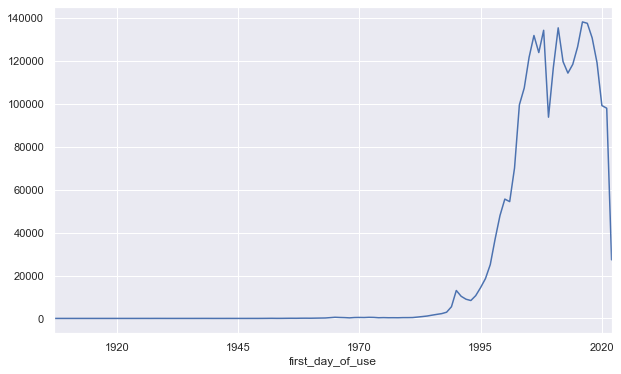

In [203]:
df['first_day_of_use'] = pd.to_datetime(
    df['kayttoonottopvm'],
    format='%Y%m%d',
    errors='coerce')

df.resample('Y', on='first_day_of_use').ajoneuvoluokka.count().plot(figsize=(10, 6))

Hmm, the latest yearly values of cars seem sensible and agree with the latest news about the number of new cars registered, but I am not sure about the older datapoints. [The documentation](https://www.traficom.fi/sites/default/files/media/file/Avoin%20Data%2010%20kysytyint%C3%A4%20kysymyst%C3%A4.pdf) on Traficom's website reveals that the data only contains vehicles that have not been decommissioned. That might explain things. It's probably better to focus on the last ten years or so for any analysis as the numbers don't exactly match e.g. the ones shown on [the website of Autoalan Tiedotuskeskus](https://www.aut.fi/tilastot/ensirekisteroinnit/ensirekisterointien_vuosittainen_kehitys) even though they are in the right ballpark.

### What's the most popular car brand in Finland?

There's a gazilliong things you could dig out of this dataset but let's just pick one thing here: In the last ten years or so, what are the most popular car brands in Finland?

As a first step, let's look at the 30 most popular brands from 2010 onwards:

In [204]:
df.query('first_day_of_use > "2009-12-31"')['merkkiSelvakielinen'].value_counts().head(30)

Toyota            174487
Volvo             122651
Skoda             121543
Volkswagen, VW    120403
Mercedes-Benz     108587
Ford              100140
BMW                79618
Kia                79095
Audi               75403
Nissan             73693
Opel               59574
Volkswagen         49822
Hyundai            40568
Peugeot            34295
Renault            28302
Honda              27353
Citroen            25814
Seat               22952
Mitsubishi         22306
Mazda              20283
Subaru             11817
Suzuki             11708
Dacia              11635
Tesla               6697
Fiat                6289
Lexus               5180
Chevrolet           4848
Mini                4128
Porsche             3873
Land Rover          3455
Name: merkkiSelvakielinen, dtype: int64

Makes sort of sense, Toyota is popular here... but wait! Why do we have both `Volkswagen, VW` and `Volkswagen` in there? Well, as they say, 90% of data science work is cleaning data, and we are not even doing that much data science here. There's probably more dirty data beneath the surface but let's just clean this Volkswagen part:

In [205]:
df['merkkiSelvakielinen'].replace({'Volkswagen, VW': 'Volkswagen'}, inplace=True)
df.query('first_day_of_use > "2009-12-31"')['merkkiSelvakielinen'].value_counts().head(5)

Toyota           174487
Volkswagen       170225
Volvo            122651
Skoda            121543
Mercedes-Benz    108587
Name: merkkiSelvakielinen, dtype: int64

Seems like that did the trick. Now it's a red hot race between Toyota and Volkswagen, a real nail-biter! Let's look at how the "market shares" of the top 9 brands have evolved in the recent years.

Probably there would be an easier way to do this with e.g. Seaborn but let's hack the [small multiple](https://en.wikipedia.org/wiki/Small_multiple) plot with just Matplotlib. Pardon for the aggressive chaining of Pandas methods!

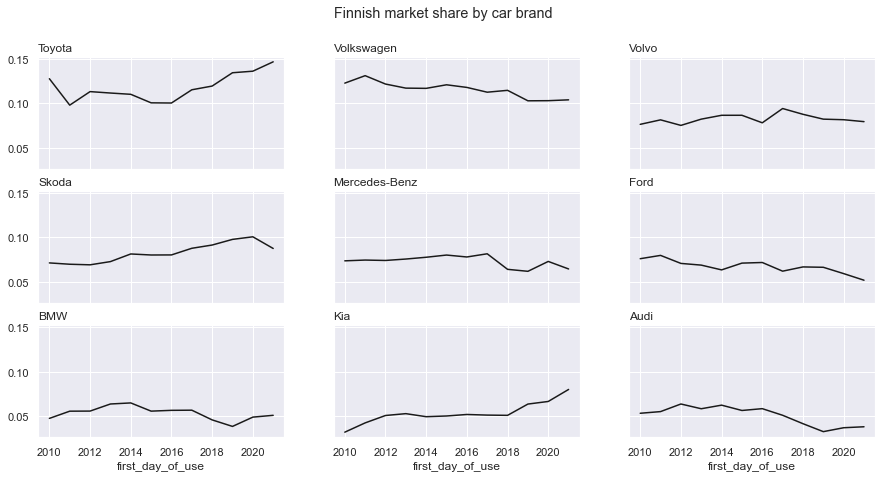

In [217]:
brands_to_include = [
    'Toyota',
    'Volkswagen',
    'Volvo',
    'Skoda',
    'Mercedes-Benz',
    'Ford',
    'BMW',
    'Kia',
    'Audi',
]

# Filter in only the data we want
df_pivot = (
    df
    .query('first_day_of_use > "2009-12-31"')
    .query('first_day_of_use < "2022-01-01"') # Include only full years
)

# Groupby, aggregate count of rows, and pivot
df_pivot = (
    df_pivot
    .groupby(
        [df_pivot.first_day_of_use.dt.year, df_pivot.merkkiSelvakielinen],
        as_index=True)['ajoneuvoluokka']
    .count()
    .reset_index()
    .pivot(
        index='first_day_of_use',
        columns='merkkiSelvakielinen', 
        values='ajoneuvoluokka')
    .fillna(0)
)

# Normalize monthly values
df_pivot = df_pivot.divide(df_pivot.sum(axis=1), axis=0)

# Plot small multiples
fig, ax = plt.subplots(3, 3, figsize=(15, 7), sharex=True, sharey=True)
for ix, col in enumerate(brands_to_include):
    plt.subplot(3, 3, ix+1)
    df_pivot[col].plot(color='k', linewidth=1.5)
    plt.title(col, loc='left')

_ = plt.suptitle('Finnish market share by car brand')

One could argue the following trends based on the data:
- Volkswagen is declining steadily, although Skoda from the same conglomerate has been going up until 2021.
- Kia has been increasing their market share in the recent years. This makes sense if you have been reading the headlines on the car market in Finland.
- Toyota has been increasing their market share in the recent years. Toyota has always been a popular and respectable choice for a family car in Finland, and perhaps their investments in the hybrid technology are paying off? 

###  What could be next?

I will stop here with this toy analysis, but there are some more interesting but also more laborious questions that you could try to answer based on this dataset. For example:
- Do Finns buy (or at least register) more electric or hybrid cars? The data has information about this in the columns `kayttovoima`, `sahkohybridi`, and `sahkohybridinluokka` but a quick glance indicates that they would require some cleaning.
- Have the cars got cleaner over time, i.e. do they emit less CO2 emissions? There's the `Co2` column in the data that could be used here.
- If they have got cleaner, is that on the expense of performance? I think `suurinNettoteho` would be helpful here.

If you got this far, why not go ahead and [watch the music video for Gary Numan's Cars](https://www.youtube.com/watch?v=Im3JzxlatUs)?